In [706]:
from os import listdir
from os.path import join, isfile
from deap import base, creator, tools, algorithms

import random
import numpy as np
import matplotlib.pyplot as plt

plt_styles = plt.style.available
plt.style.use(plt_styles[7])


In [707]:
def get_data_from_file(path: str):
    with open(path, "r") as f:
        data = []
        lines = f.readlines()
        for line in lines:
            data.append([int(c) for c in line.split()])
        return data


def get_paths_of_dir(path: str, extension: str):
    return [join(path, f) for f in listdir(path)
            if isfile(join(path, f)) and f.endswith(extension)]

In [708]:
inDirPath = "../../Input/"
inPaths = get_paths_of_dir(inDirPath, extension=".in")

In [709]:
n_problem = int(input(f"Elige el problema (1-{len(inPaths)}): "))

inDirFiles = listdir(inDirPath)
file_name = inDirFiles[n_problem - 1]

path = inPaths[n_problem - 1]
prob = get_data_from_file(path)

## Variable meanings.

* R = Number of rows.
* C = Number of columns.
* F = Number of cars.
* N = Pre-booked rides.
* B = Per-ride bonus for starting the ride on time.
* T = Simulation steps = distance between start and end.

In [710]:
# Problem data.
_, _, F, N, B, T = prob[0]

# Rides.
rides = prob[1:-1]

# Car accessibility.
adapted = prob[-1]

Bonus:
* Earn points proportional to distance of ride.
* Bonus if started on time. 

In [711]:
toolbox = base.Toolbox()

In [712]:
if not hasattr(creator, "FitnessMax"):
    creator.create("FitnessMax", base.Fitness, weights=(1.0, -1.0))

if not hasattr(creator, "Individual"):
    creator.create("Individual", list, fitness=creator.FitnessMax)

In [713]:
toolbox.register("attribute", random.randint, 0, F - 1)
toolbox.register("individual", tools.initRepeat,
                 creator.Individual, toolbox.attribute, n=N)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [714]:
def col(a, *n_cols):
    cols = []
    for n in n_cols:
        col = np.array(a)[:, n]
        cols.append(col)
    return cols


def get_pareto_front(pop):
    fitness = []
    penalty = []
    pairs = []

    # Get fitness and penalty.
    for ind in pop:
        f, p = eval_ind(ind)
        fitness.append(f)
        penalty.append(p)
        pairs.append([f, p])

    # Get frontier.
    sorted_pairs = sorted(pairs, reverse=True)
    front = [sorted_pairs[0]]

    for pair in sorted_pairs[1:]:
        if pair[1] < front[-1][1]:
            front.append(pair)

    f_front = [f for f, _ in front]
    p_front = [p for _, p in front]

    _, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(fitness, penalty, alpha=0.6, label="Population")
    ax.plot(f_front, p_front, "-o", color="b", label="Pareto Front")
    ax.tick_params(axis="x", rotation=30)
    ax.set_ylabel("Penalty")
    ax.set_xlabel("Fitness")

    legend = plt.legend(loc="best", shadow=True, edgecolor="black",
                        borderpad=1, labelspacing=0.8, facecolor="whitesmoke")
    plt.setp(legend.get_texts(), color="black")
    plt.show()


def plot_dif_scales(lb):
    gen = lb.select("gen")
    avgs = lb.select("avg")
    mins = lb.select("min")
    maxs = lb.select("max")

    fit_avgs, pen_avgs = col(avgs, 0, 1)
    fit_maxs, pen_maxs = col(maxs, 0, 1)
    fit_mins, pen_mins = col(mins, 0, 1)

    _, ax = plt.subplots(figsize=(6, 4))

    c_ax, c_ax2 = ["r", "b"]
    linewidth = 2
    line_alpha = 0.6
    grid_alpha = 0.1

    ax.plot(gen, fit_avgs, color=c_ax, linewidth=linewidth, alpha=line_alpha)
    ax.plot(gen, fit_maxs, color=c_ax, linewidth=linewidth, alpha=line_alpha)
    ax.plot(gen, fit_mins, color=c_ax, linewidth=linewidth, alpha=line_alpha)
    ax.tick_params(axis="y", labelcolor=c_ax)
    ax.set_xlabel("Generations")
    ax.set_ylabel("Fitness", color=c_ax)
    ax.grid(alpha=grid_alpha, color=c_ax)

    ax2 = ax.twinx()
    ax2.plot(gen, pen_avgs, color=c_ax2, linewidth=linewidth, alpha=line_alpha)
    ax2.plot(gen, pen_maxs, color=c_ax2, linewidth=linewidth, alpha=line_alpha)
    ax2.plot(gen, pen_mins, color=c_ax2, linewidth=linewidth, alpha=line_alpha)
    ax2.tick_params(axis="y", labelcolor=c_ax2)
    ax2.set_ylabel("Penalty", color=c_ax2)
    ax2.grid(alpha=grid_alpha, color=c_ax2)

    plt.show()


def plot_dif_scales_separate(lb):
    gen = lb.select("gen")
    avgs = lb.select("avg")
    mins = lb.select("min")
    maxs = lb.select("max")

    fit_avgs, pen_avgs = col(avgs, 0, 1)
    fit_maxs, pen_maxs = col(maxs, 0, 1)
    fit_mins, pen_mins = col(mins, 0, 1)

    _, ax = plt.subplots(2, figsize=(6, 4))

    c_max, c_avg, c_min = ["r", "g", "b"]
    linewidth = 2
    line_alpha = 0.6
    grid_alpha = 0.1

    ax[0].plot(gen, fit_avgs, color=c_avg,
               linewidth=linewidth, alpha=line_alpha)
    ax[0].plot(gen, fit_mins, color=c_min,
               linewidth=linewidth, alpha=line_alpha)
    ax[0].plot(gen, fit_maxs, color=c_max,
               linewidth=linewidth, alpha=line_alpha)
    ax[0].set_xlabel("Generations")
    ax[0].tick_params(axis="y")
    ax[0].set_ylabel("Fitness")
    ax[0].grid(alpha=grid_alpha)

    ax[1].plot(gen, pen_avgs, color=c_avg,
               linewidth=linewidth, alpha=line_alpha)
    ax[1].plot(gen, pen_maxs, color=c_max,
               linewidth=linewidth, alpha=line_alpha)
    ax[1].plot(gen, pen_mins, color=c_min,
               linewidth=linewidth, alpha=line_alpha)
    ax[1].set_xlabel("Generations")
    ax[1].tick_params(axis="y")
    ax[1].set_ylabel("Penalty")
    ax[1].grid(alpha=grid_alpha)

    plt.show()


In [715]:
def sort_rides(car_rides):
    def sort_ride(ride):
        a, b, x, y, s, f, _ = ride
        origin = [a, b]
        destiny = [x, y]
        distance = dis(origin, destiny)

        return s + f - distance

    return sorted(car_rides, key=lambda ride: sort_ride(ride[1]))


def get_rides_from_ind(individual):
    cars_rides = np.full(F, None)

    for i, car in enumerate(individual):
        v_r = cars_rides[car]

        if v_r is None:
            v_r = []

        ride = rides[i]
        v_r.append([i, ride])

        cars_rides[car] = v_r

    return cars_rides


def dis(a, b): return np.abs(a[0] - b[0]) + np.abs(a[1]-b[1])


def get_penalty(adapted_car, adapted_ride):
    if adapted_car == 0 and adapted_ride == 1:
        return 1
    return 0


In [716]:
def calc_fitness(car, car_rides):
    fitness = 0
    penalty = 0
    step = 0
    pos = [0, 0]

    # Sort car_rides given earliest time.
    car_rides = sort_rides(car_rides)

    for _, ride in car_rides:
        a, b, x, y, earliest_start, latest_finish, adapted_ride = ride
        origin = [a, b]
        destiny = [x, y]

        adapted_car = adapted[car]

        # 0.- Set penalty of adaptability of car/ride.
        penalty += get_penalty(adapted_car, adapted_ride)

        # 1.- Go to origin.
        step += dis(pos, origin)

        # 2.- If arrived before the earliest time. Wait and earn bonus.
        if step <= earliest_start:
            fitness += B
            step = earliest_start

        # 3.- Go to destiny.
        dis_ori_des = dis(origin, destiny)
        step += dis_ori_des

        # 4.- If reached destiny before latest finish. Earn points.
        if step <= latest_finish:
            fitness += dis_ori_des

        # 5.- Update position.
        pos = destiny

        # 6.- Check if reached max distance with one car.
        if step > T:
            break

    return fitness, penalty


def eval_ind(ind):
    all_rides = get_rides_from_ind(ind)

    fitness = 0
    penalty = 0

    for car, car_rides in enumerate(all_rides):
        if car_rides is not None:
            _fitness, _penalty = calc_fitness(car, car_rides)
            fitness += _fitness
            penalty += _penalty

    return fitness, penalty


In [717]:
INDPB = 0.2

toolbox.register("select", tools.selNSGA2)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutUniformInt, indpb=INDPB, low=0, up=F-1)
toolbox.register("evaluate", eval_ind)

In [718]:
INIT_NIND = 300

pop = toolbox.population(n=INIT_NIND)
hof = tools.ParetoFront()

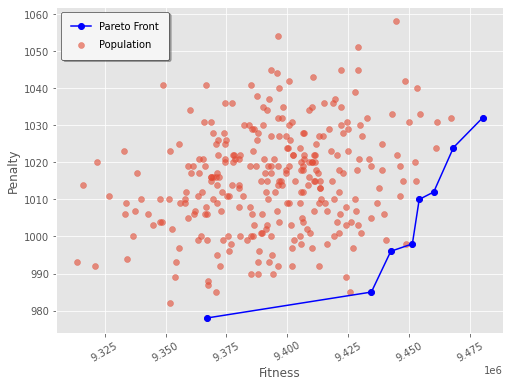

Number of individuals: 300


In [719]:
# Pareto front from first population.
get_pareto_front(pop)
print(f"Number of individuals: {len(pop)}")


In [720]:
ind = toolbox.individual()

print("Individuo")
print(ind[1:20])

print("Individuo ANTES de evaluar")
print(f"Valid: {ind.fitness.valid}")

ind.fitness.values = eval_ind(ind)

print("Individuo TRAS evaluar")
print(f"Valid: {ind.fitness.valid}. Fitness = {ind.fitness.values}")

Individuo
[58, 34, 31, 30, 79, 33, 70, 27, 73, 68, 32, 27, 53, 26, 4, 38, 80, 44, 26]
Individuo ANTES de evaluar
Valid: False
Individuo TRAS evaluar
Valid: True. Fitness = (9440546.0, 1022.0)


In [721]:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)
stats.register("std", np.std, axis=0)
stats.register("avg", np.average, axis=0)


In [722]:
NGEN = 30

MU = int(0.7*INIT_NIND) # Límite de invididuos en población.
LAMBDA = int(3.6*INIT_NIND) # Creación de hijos en cada generación. Aumenta población hasta MU.
CXPB = 0.5
MUTPB = 0.5

pop, logbook = algorithms.eaMuPlusLambda(
    pop, toolbox, MU, LAMBDA, CXPB, MUTPB, NGEN, stats, halloffame=hof, verbose=False)

In [723]:
best_sol = tools.selBest(pop, k=1)[0]

print(f"El resultado de la evolución es:")
print(logbook)
print(
    f"Mejor solución es {best_sol[1:10]} con fitness {eval_ind(best_sol)}")


El resultado de la evolución es:
gen	nevals	min                        	max                        	std                            	avg                            
0  	300   	[9.313506e+06 9.780000e+02]	[9.480156e+06 1.058000e+03]	[3.03204832e+04 1.41034476e+01]	[9.39545588e+06 1.01519000e+03]
1  	1080  	[9.351722e+06 9.750000e+02]	[9.485546e+06 1.053000e+03]	[2.83354514e+04 1.67754166e+01]	[9.43002630e+06 1.00693333e+03]
2  	1080  	[9.32341e+06 9.58000e+02]  	[9.499913e+06 1.049000e+03]	[3.60987750e+04 1.94304528e+01]	[9.43842030e+06 1.00078095e+03]
3  	1080  	[9.320689e+06 9.440000e+02]	[9.507297e+06 1.048000e+03]	[3.97896371e+04 2.12874874e+01]	[9.44539226e+06 9.95138095e+02]
4  	1080  	[9.341269e+06 9.400000e+02]	[9.521151e+06 1.051000e+03]	[3.88273933e+04 2.44621861e+01]	[9.45257224e+06 9.91438095e+02]
5  	1080  	[9.341269e+06 9.400000e+02]	[9.534927e+06 1.051000e+03]	[4.48287927e+04 2.49684808e+01]	[9.45425094e+06 9.85314286e+02]
6  	1080  	[9.341269e+06 9.400000e+02]	[9.542709e+

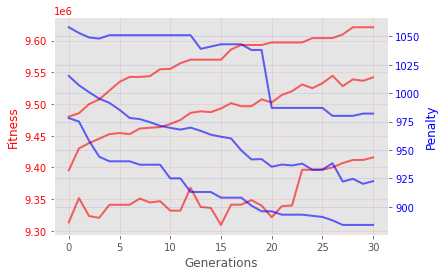

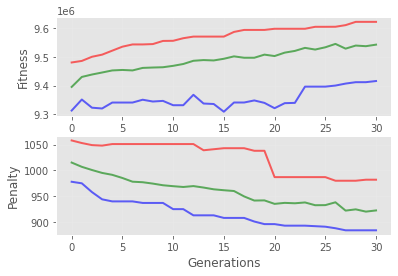

In [724]:
plot_dif_scales(logbook)
plot_dif_scales_separate(logbook)

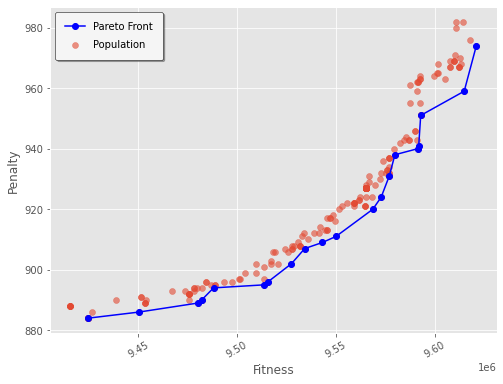

Number of individuals: 210


In [725]:
# Pareto front from last population.
get_pareto_front(pop)
print(f"Number of individuals: {len(pop)}")


In [726]:
outDirPath = "../../Output/"
outFilePath = outDirPath + file_name.strip(".in") + ".out"

cars_rides = get_rides_from_ind(best_sol)

with open(outFilePath, "w") as f:
    for v_r in cars_rides:
      if v_r is None:
        f.write(str(0))
      else:
        v_r = sort_rides(v_r)    
        f.write(str(len(v_r)))
        f.write(" ")
        f.write(" ".join(str(pos) for pos, _ in v_r))
      
      f.write("\n")